# Employee Turnover Prediction Starter Workbook

This workbook was started by the data scientist who originally worked on this project. It is organized around the following steps:
1. Import and Clean data
2. Explore data
3. Model features
4. Model data
5. Evaluate models

In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Model

In [3]:
#Read in the data files
train = pd.read_csv("assets/train.csv",sep=",")
validate = pd.read_csv("assets/validate.csv",sep=",")
test = pd.read_csv("assets/test.csv",sep=",")

In [4]:
#Examine the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         5088 non-null   int64  
 1   Attrition                          5088 non-null   int64  
 2   Age                                5088 non-null   int64  
 3   DistanceFromHome                   5088 non-null   int64  
 4   Education                          5088 non-null   int64  
 5   JobLevel                           5088 non-null   int64  
 6   MonthlyIncome                      5088 non-null   int64  
 7   NumCompaniesWorked                 5088 non-null   float64
 8   PercentSalaryHike                  5088 non-null   int64  
 9   StockOptionLevel                   5088 non-null   int64  
 10  TotalWorkingYears                  5088 non-null   float64
 11  TrainingTimesLastYear              5088 non-null   int64

In [5]:
#Let's view some of the sample data
pd.set_option("display.max_columns", None)
train.head()

,Unnamed: 0,Attrition,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human_Resources,Department_Research_Development,Department_Sales,JobRole_Healthcare_Representative,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,Age_sd,DistanceFromHome_sd,MonthlyIncome_sd,NumCompaniesWorked_sd,PercentSalaryHike_sd,TotalWorkingYears_sd,TrainingTimesLastYear_sd,YearsAtCompany_sd,YearsSinceLastPromotion_sd,YearsWithCurrManager_sd,PerformanceRating_sd,JobInvolvement_sd,EnvironmentSatisfaction_sd,JobSatisfaction_sd,WorkLifeBalance_sd
0,0,0,31,2,2,3,42850,1.0,17,1,1.0,2,1,1,0,4,3,4.0,4.0,4.0,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,-0.648575,-0.838962,-0.472354,-0.676803,0.623603,-1.320984,-0.617511,-0.982420,-0.371055,-1.159367,1.628180,-0.037748,0.986956,0.958052,1.072279
1,1,1,30,1,3,3,179240,1.0,10,2,10.0,2,10,6,7,2,3,3.0,1.0,3.0,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,-0.757951,-0.979530,2.422511,-0.676803,-1.058227,-0.165412,-0.617511,0.486798,1.184830,0.805966,-1.548202,-0.037748,0.045662,-2.200674,-0.020446
2,2,1,45,23,4,3,34410,2.0,8,1,5.0,5,1,0,0,2,2,3.0,4.0,2.0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,0.882689,2.112975,-0.651493,-0.275889,-1.538750,-0.807397,1.715806,-0.982420,-0.682232,-1.159367,-1.548202,-1.204968,0.045662,0.958052,-1.113171
3,3,0,35,1,3,1,108550,3.0,13,1,17.0,2,8,1,6,3,4,3.0,2.0,4.0,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,-0.211071,-0.979530,0.922122,0.125025,-0.337443,0.733366,-0.617511,0.160305,-0.371055,0.525204,0.039989,1.129473,0.045662,-1.147766,1.072279
4,4,1,26,18,2,2,26130,6.0,15,1,6.0,2,4,1,2,2,2,2.0,3.0,2.0,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,-1.195455,1.410133,-0.827235,1.327768,0.143080,-0.679000,-0.617511,-0.492681,-0.371055,-0.597843,-1.548202,-1.204968,-0.895632,-0.094857,-1.113171


In [6]:
#Drop an extraneous column and determine the shape of the train data frame.
train=train.drop(['Unnamed: 0'], axis=1)
test=test.drop(['Unnamed: 0'], axis=1)
validate=validate.drop(['Unnamed: 0'], axis=1)
train.shape

(5088, 49)

#### Design Note 1.1

The data were explored, cleaned, and prepared for analysis in the notebook 1_employee_turn_data_prep.ipynb. This notebook contains a start to the model building process. We wil explore a basic model and some discussion of performance metrics. There are several Python packages that can be used to create a logistic regression model, and two of the more popular is scikit-learn and statsmodel. Scikit-learn is a machine learning package, whereas statsmodel falls more within the statistical tradition. Statsmodel provides some useful statistical output (```p-values```, ```coeff```, ```intervals```). Scikit-learn provides good fit metrics (```precision```, ```recall```, ```confusion matrix```) and fits within a machine learning model. Given that we want to do both explanatory and predictive modeling, we will use statsmodel in this file to create our model, which offers some nice statistical output, but we also will leverage some of scikit-learn and its fit metrics. For this initial exploratory modeling, we will use statsmodels for the primary modeling and statistical evaluation, but we will also lean heavily on many of the advanced fit metrics that scikit-learn provides.

In [10]:
# First, we setup a baseline model using statsmodel. We can use the logit model in statsmodel and our training data set
# to create a basic model. Attrition is our y-variable. We'll include a few predictors that seem to have
# potential as predictors.
# For those familiar with the r-programming lanugage, the syntax of statsmodels should feel familiar.

log_reg = sm.logit(formula="Attrition ~ Age_sd + DistanceFromHome_sd + Education + JobLevel + "
                            "MonthlyIncome_sd + NumCompaniesWorked_sd + PercentSalaryHike_sd + "
                            "StockOptionLevel + TotalWorkingYears_sd + TrainingTimesLastYear_sd + "
                            "YearsAtCompany_sd + YearsSinceLastPromotion_sd + YearsWithCurrManager_sd + "
                            "PerformanceRating_sd + JobInvolvement_sd + EnvironmentSatisfaction_sd + "
                            "JobSatisfaction_sd + WorkLifeBalance_sd + "
                            "BusinessTravel_Travel_Frequently + BusinessTravel_Travel_Rarely + "
                            "Department_Research_Development + "
                            "Department_Sales + "
                            "JobRole_Human_Resources + JobRole_Laboratory_Technician + JobRole_Manager + "
                            "JobRole_Manufacturing_Director + JobRole_Research_Director + "
                            "JobRole_Research_Scientist + JobRole_Sales_Executive + "
                            "JobRole_Sales_Representative", data=train).fit()

PatsyError: Error evaluating factor: NameError: name 'BusinessTravel_None' is not defined
    Attrition ~ Age_sd + DistanceFromHome_sd + Education + JobLevel + MonthlyIncome_sd + NumCompaniesWorked_sd + PercentSalaryHike_sd + StockOptionLevel + TotalWorkingYears_sd + TrainingTimesLastYear_sd + YearsAtCompany_sd + YearsSinceLastPromotion_sd + YearsWithCurrManager_sd + PerformanceRating_sd + JobInvolvement_sd + EnvironmentSatisfaction_sd + JobSatisfaction_sd + WorkLifeBalance_sd + BusinessTravel_None + BusinessTravel_Travel_Frequently + BusinessTravel_Travel_Rarely + Department_Human_Resources + Department_Research_Development + Department_Sales + JobRole_Healthcare_Representative + JobRole_Human_Resources + JobRole_Laboratory_Technician + JobRole_Manager + JobRole_Manufacturing_Director + JobRole_Research_Director + JobRole_Research_Scientist + JobRole_Sales_Executive + JobRole_Sales_Representative
                                                                                                                                                                                                                                                                                                                                                                                                          ^^^^^^^^^^^^^^^^^^^

#### Design Note 1.2: Statistical Evaluation of the Model

One advantage of statsmodel is that it offers robust statistical reporting on models. By printing the ```summary()``` of the log, we can view some key aspects of model performance.

```Pseudo R-squ.```: In conventional linear regression, one metric of quality is R2, which represents the proportion of the variance in the dependent variable that is explained by the model. An R2 of 40% suggests that 40% of the variation of the dependent variable is explained by the independent variables. Because logistic regression does not utilize ordinary-least squares for fitting a model, it is not calculated to minimize variance, so R2 as a goodness-of-fit metric does not translate. Instead, we must use a psuedo-R2. Psuedo-R2 looks like traditional R2 in that it also ranges from 0 to 1, but it does not have the same intuition as R2. Psuedo-R2 is a relative metric that can be used to compare models on the same set of data.

```coef```: The coef. column contains the coefficient for each variable in the model. This helps us in model interpretation. If this were linear regression, we know that a 1 unit change in the x-variable would produce a ```coef``` change in the y-variable. For example, if we are modeling home size (sq ft) vs. home price ($), the coef would tell us that a 1 sq ft increase in size will impact home price by ```coef``` dollars. The intuition works differently in logistic regression. Because the exponents are expressed in log-odds, we have to exponentiate them to interpret them. Doing so will tell us how the odds change give the coefficient.

```P>|z|```: This column shows which variables are statistically significant. Anything below 0.05 would traditionally be considered statistically significant. Statistical significance is not the end-all-be-all. It can help in manually building explanatory models, informing variable inclusion decisions. For machine learning, we may well include non-statistically significant variables to improve predictive utility. Better metrics to judge if it is worth including a variable in model are those that consider model complexity vs. performance, such as AIC and BIC.

```[0.025  0.975]```: These columns provide a confidence interval around the coefficients, so we can consider uncertainty in our analysis. 

In [7]:
#Now that we fit a baseline model, we can examine some of the output to understand the results.
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 5174
Model:                          Logit   Df Residuals:                     5171
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:                 0.02824
Time:                        18:12:59   Log-Likelihood:                -3485.1
converged:                       True   LL-Null:                       -3586.3
Covariance Type:            nonrobust   LLR p-value:                 1.026e-44
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0552      0.029     -1.924      0.054      -0.111       0.001
Age_sd              -0.4083      0.030    -13.665      0.000      -0.467      -0.350
MonthlyIncome_sd    -0.0907 

In [8]:
# Another way to veiw the model coefficients
print(log_reg.params)

Intercept          -0.055194
Age_sd             -0.408347
MonthlyIncome_sd   -0.090675
dtype: float64


The model summary states that "A fraction 0.17 of observations can be perfectly predicted. This might indicate that there is complete quasi-separation." This might be a result of the one hot encoded dummy variables. Thus, let's create a model devoid of these variables and see if the model improves.

In [ ]:
model_quant = sm.logit(formula="Attrition ~ Age_sd + DistanceFromHome_sd + Education + JobLevel + "
                               "MonthlyIncome_sd + NumCompaniesWorked_sd + PercentSalaryHike_sd + "
                               "StockOptionLevel + TotalWorkingYears_sd + TrainingTimesLastYear_sd + "
                               "YearsAtCompany_sd + YearsSinceLastPromotion_sd + YearsWithCurrManager_sd + "
                               "PerformanceRating_sd + JobInvolvement_sd + EnvironmentSatisfaction_sd + "
                               "JobSatisfaction_sd + WorkLifeBalance_sd", data=train).fit()

#### Design Note 1.3: Exponentiating coefficients

As mentioned previously, logisitic regression coefficients are expressed in log-odds. In order to interpret them as odds-ratios, we have exponentiate them. Mathematically, if we take the mathematical constant e and raise it to the power of our coefficient, we will convert our values from log-odds to odds (e^[ln(OR)]). Recall that odds ratio represents a ratio of probabilities: if there is an 80% chance of winning a soccer (football) match and a 20% of losing it, then the odds ratio of winning is 0.8/0.2 or 4:1 (four-to-one). If the odds of an event are even (0.5, 0.5), then the odds ratio is 0.5/0.5 = 1 (or 1:1). See the course logistic regression overview for more discussion on coefficient interpretation: ([Introduction to Logistic Regression](https://docs.google.com/document/d/1VM_JxZ64zoGGg6aAICJBPW_fnRtKIBHodubKo4eBAaI/edit?usp=sharing))


In [9]:
# Build a data frame with odds ratios and their confidence intervals.
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
# Exponentiate the data frame
odds_ratios = np.exp(odds_ratios)

# Print the results
print(odds_ratios)

                        OR  Lower CI  Upper CI
Intercept         0.946301  0.894574  1.001020
Age_sd            0.664748  0.626932  0.704845
MonthlyIncome_sd  0.913315  0.863669  0.965814


#### Design Note 1.4: Confusion Matrices

One of the standard classification quality tools is the confusion matrix. A confusion matrix can be used in multinomial situations, but in binary classification, the confusion matrix allows the data scientist to measure four classification scenarios from the model: true positive, true negative, false positive, and false negative. The definitions of the metrics are found below:

```true positive (TP)```: A true positive is when the model predicts a positive-state outcome for the dependent variable and the ground truth is also positive. For example, if we were predicting if someone has diabetes given their blood levels, a true positive result would be that our model predicts the person has diabetes and they actually do. (Note that 'positive' means we predict something will happen; it does not necessarily mean that the outcome is good).

```true negative (TN)```: A true negative is when the model predicts a negative-state outcome for the dependent variable and the ground truth is also negative. For example, if we were predicting if someon has diabetes given their blood levels, a true negative result would be that the model predicts the person does not have diabetes and they do not in reality. (Note that 'negative' means we predict something does not happen, and it does not necessary mean that the outcome is good).

A perfect model will categorize all events as either true positives or true negatives. This is highly unlikely in most modeling situations, so we must learn about classification error: false positives and false negatives. 

```false positive (FP)```: A false positive is when the model predicts a positive-state outcome for the dependent variable and the ground truth is actually negative. Using our diabetes example, a false positive occurs when the model says someone has diabetes but in reality they do not. A false positive is a category of classification error.

```false negative (FN)```: A false negative is when the model predicts a negative-state outcome for the dependent variable and the ground truth is actually positive. Using our diabetes example, a false negative occurs when the model says someone does not have diabetes but in reality they do. A false negative is a category of classification error. 


```confusion matrix```: A confusion matrix consists of two axes that define four squares. Each square provides the raw count for a specific classification metric (TP, TN, FP, FN).The key to identifying which square is associated with which classification metric is knowing if the actual (ground truth) results are the rows or the columns.

For ```statsmodels```, we use a method called pred_table() to generate a confusion matrix (though you can also use sklearn's confusion matrix tools on non-sklearn models). According to the statsmodel documentation, "pred_table[i,j] refers to the number of times “i” was observed and the model predicted “j”. Correct predictions are along the diagonal." So the confusion matrix in statsmodels, the rows represent the actual (observed) classification and the columns represent the predicted. The diagonal from upper left to lower right are the true positives and true negatives. 


In [8]:
# Create a confusion matrix for our initial model on the training data set
log_reg.pred_table()

(650, 49)

While ```statsmodels``` can provide a basic confusion matrix, ```scikit-learn``` offers much more in the way of classification metrics. Also, the confusion matrix above using our training data. Of course, if we were to evaluate modeling just on training data, we might easily find our way into overfitting. Below provides the necessary code snippets to (1) generate predictions on our test data set (how effective is our training model at predicting values that are out-of-sample?) and (2) create a basic confusion matrix as well as a more graphical representation.

In [11]:
# Building a confusion matrix on the test dataset

y_pred = log_reg.predict(test)

# Y-pred are the probabilities that each row (employee) in the test set will attrite. 
# To produce a confusion matrix work we need to change that those probabilities to binary (0,1) values. 
# This can be done by rounding the y_pred values
prediction = list(map(round, y_pred))
 

Before we populate the confusion matrix, a helpful exercise is to examine the probabilities we have produce for our test data set. In this context, these values represent the probability that individuals in the test data set will attrite.

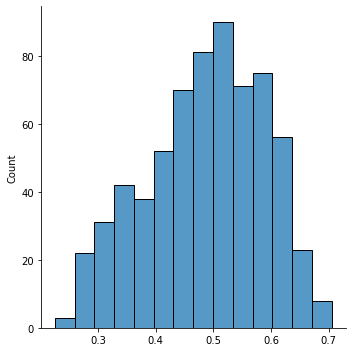

In [12]:
sns.displot(y_pred, kde=False, rug=False)

In [13]:
# Now that we have done the legwork, we can produce the desired confusion matrices.

# Create a sklearn confusion matrix
cm = confusion_matrix(test['Attrition'], prediction)
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(test['Attrition'], prediction))

Confusion Matrix : 
 [[314 247]
 [ 25  76]]
Test accuracy =  0.5891238670694864


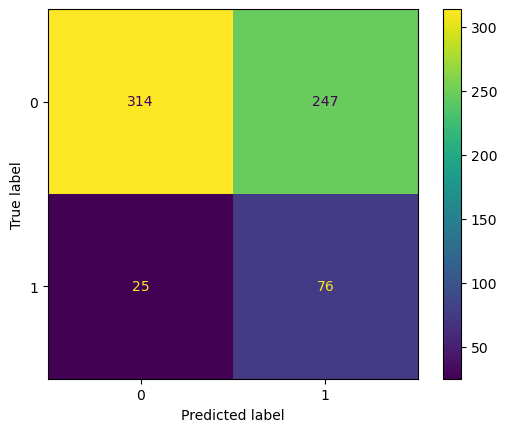

In [14]:
# Should we want a slightly more graphical display, sklearn also offers ConfusionMatrixDisplay()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Design Note 1.5: Fit metrics

As mentioned previously, the popular machine learning package ```scikit-learn``` can model several forms of regression, including logistical regression. Generally, its reporting on the statistical properities of models is not as robust as ```statsmodels```, but its fit metrics are superior. Specifically, ```scikit-learn``` provides built-in reporting for several key classification algorithms including precision, recall, F1, and AUC. We will use this metrics to better understand the complexities of our model performance. Below are some basic definitions for some of the fit metrics. For a more detailed discussion, refer to the course logistic regression guide: ([Introduction to Logistic Regression](https://docs.google.com/document/d/1VM_JxZ64zoGGg6aAICJBPW_fnRtKIBHodubKo4eBAaI/edit?usp=sharing))

Recall: A measure of a classifier's completeness <br>
How many relevant items are selected? <br>
Recall: TP / Real Positive = TP / (TP + FN) <br>
A model that produces no false negatives has a recall of 1.0.

Precision: A measure of a classifier's exactness.<br>
How many selected items are relevant?<br>
Precision: TP / Predicted Positive = TP / (TP + FP)<br>
A model that produces no false positives has a precision of 1.0.

F1-score:  the harmonic mean of precision and recall.

Sklearn provides a helpful classification report to provide a view into precision, recall, and f1-score. It provides these values for the overall model and disaggreagted by response variable outcome (0,1).

In [15]:
# Classification_report() has two required fields: the ground truth (y) and the binary predicted values (pred)

print(classification_report(test['Attrition'],prediction))

              precision    recall  f1-score   support

           0       0.93      0.56      0.70       561
           1       0.24      0.75      0.36       101

    accuracy                           0.59       662
   macro avg       0.58      0.66      0.53       662
weighted avg       0.82      0.59      0.65       662


#### Design Note 1.6: Graphic representations of fit

A final way we will explore the quality of our classification model (in this preliminary exploration) is examining a ROC curve (receiver operating characteristic curve). The name is a bit opaque, but in essence, the ROC curve plots the True Positive Rate (TPR --- also called recall) against the False Positive Rate (FPR --- defined as FP/(FP + TN)). When we plot this curve, we can consider the trade-off in false positive vs. true positive rate given a decision threshold. It also plots a curve (as its name implies) which gives a visual representation of model performance. Lastly, we can take the integral of the ROC curve we plot to calculate the area under the curve (AUC). A model that has no correct predictions would have the worst possible AUC score (0.0); a model with very prediction correct (only true positives and true negatives) would have the maxmimum AUC score (1.0).

In [16]:
# First we use sklearn's roc_auc_score() function to find the area under the curve for our initial model. 
# Having calculated this value, we can then plot in on a graph along with our ROC curve.

auc=roc_auc_score(test['Attrition'],y_pred )
print(auc)

0.7031644340904679


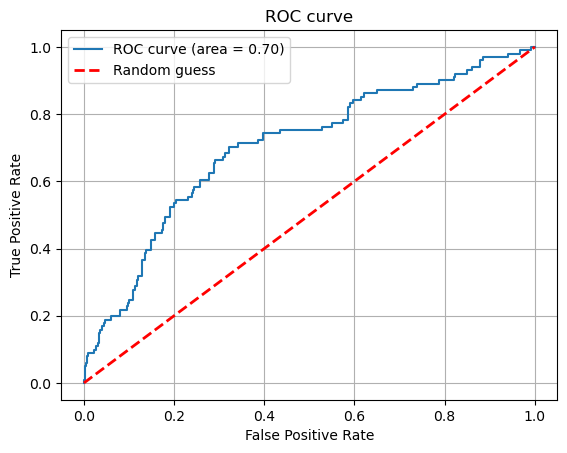

In [17]:
# Use Scikit-learn's ROC Curve Utility to plot ROC curve. For reference, we also include a 'line of determination (y=x)',
# which represents no lift from the model (just random guessing, the worst kind of model performance).
# Our goal is to produce a model that separates from the line of determination and captures as much of the area above the line
# as possible. 

fpr, tpr, thresholds = roc_curve(test['Attrition'],  y_pred)

# Create ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()
plt.show()